# 初始化

In [0]:
#@markdown - **挂载** 
from google.colab import drive
drive.mount('GoogleDrive')

In [0]:
# #@markdown - **卸载**
# !fusermount -u GoogleDrive

# 代码区

In [0]:
#@title 深度卷积生成网络 { display-mode: "both" }
# Deep Convolutional Generative Adversarial Networks
# 该程序通过三层卷积神经网络实现了 DCGAN 在人脸数据集 FaceWarehouse 上的应用
# 输入图像的大小为 45 * 38
#@markdown [参考程序](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/dcgan.ipynb)
#@markdown [参考文章](https://arxiv.org/pdf/1511.06434.pdf)
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy.io as scio

tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
#@markdown - **定义LeakyReLU 激活函数**
def leakyrelu(x, alpha=0.2):
    return 0.5 * (1 + alpha) * x + 0.5 * (1 - alpha) * abs(x)

In [0]:
#@markdown - **定义生成器**
def generator(x, batch_size, noise_dim, num_neuron, is_training, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse): # 变量域，需要重复调用时必须设置 reuse 为 True
        with tf.name_scope('FC'):
            w_fc = tf.get_variable(name='weights_fc', shape=[noise_dim, num_neuron], initializer=tf.initializers.truncated_normal(stddev=0.1))
            b_fc = tf.get_variable(name='bias_fc', initializer=tf.constant(0.1, shape=[num_neuron]))
            layer_1 = tf.matmul(x, w_fc) + b_fc
            layer_1_bn = tf.layers.batch_normalization(layer_1, training=is_training) # 批量归一化1
            layer_1_op = tf.nn.relu(layer_1_bn)
        with tf.name_scope('Conv1'):
            x_imgs = tf.reshape(layer_1_op, shape=[batch_size, 6, 5, 64], name='layer1_imgs')
            w_c1 = tf.get_variable(name='weights_c1', shape=[5, 5, 32, 64], initializer=tf.initializers.truncated_normal(stddev=0.1))
            b_c1 = tf.get_variable(name='bias_c1', initializer=tf.constant(0.1, shape=[32]))
            layer_c1 = tf.nn.conv2d_transpose(x_imgs, w_c1, output_shape=[batch_size, 12, 10, 32], strides=[1, 2, 2, 1], padding='SAME') + b_c1
            layer_c1_bn = tf.layers.batch_normalization(layer_c1, training=is_training) # 批量归一化2
            layer_c1_op = tf.nn.relu(layer_c1_bn)
#             layer_c1_op = tf.nn.relu(layer_c1)
        with tf.name_scope('Conv2'):
            w_c2 = tf.get_variable(name='weights_c2', shape=[5, 5, 16, 32], initializer=tf.initializers.truncated_normal(stddev=0.1))
            b_c2 = tf.get_variable(name='bias_c2', initializer=tf.constant(0.1, shape=[16]))
            layer_c2 = tf.nn.conv2d_transpose(layer_c1_op, w_c2, output_shape=[batch_size, 23, 19, 16], strides=[1, 2, 2, 1], padding='SAME') + b_c2
            layer_c2_bn = tf.layers.batch_normalization(layer_c2, training=is_training) # 批量归一化3
            layer_c2_op = tf.nn.relu(layer_c2_bn)
        with tf.name_scope('Conv3'):
            w_c3 = tf.get_variable(name='weights_c3', shape=[5, 5, 1, 16], initializer=tf.initializers.truncated_normal(stddev=0.1))
            b_c3 = tf.get_variable(name='bias_c3', initializer=tf.constant(0.1, shape=[1]))
            layer_c3 = tf.nn.conv2d_transpose(layer_c2_op, w_c3, output_shape=[batch_size, 45, 38, 1], strides=[1, 2, 2, 1], padding='SAME') + b_c3
        with tf.name_scope('Output'):
            x_op = tf.nn.tanh(layer_c3, name='output_gen') # 输出激活函数保证值域在 [-1, 1]
    return x_op

In [0]:
#@markdown - **定义判别器**
def discriminator(x, is_training, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        with tf.name_scope('Conv1'):
            w_c1 = tf.get_variable(name='weights_c1', shape=[5, 5, 1, 64], initializer=tf.initializers.truncated_normal(stddev=0.1))
            b_c1 = tf.get_variable(name='bias_c1', initializer=tf.constant(0.1, shape=[64]))
            layer_c1 = tf.nn.conv2d(x, w_c1, strides=[1, 2, 2, 1], padding='SAME') + b_c1
            layer_c1_bn = tf.layers.batch_normalization(layer_c1, training=is_training) # 批量归一化1
            layer_c1_op = leakyrelu(layer_c1_bn)
#             layer_c1_op = tf.nn.relu(layer_c1_bn)
        with tf.name_scope('Conv2'):
            w_c2 = tf.get_variable(name='weights_c2', shape=[5, 5, 64, 128], initializer=tf.initializers.truncated_normal(stddev=0.1))
            b_c2 = tf.get_variable(name='bias_c2', initializer=tf.constant(0.1, shape=[128]))
            layer_c2 = tf.nn.conv2d(layer_c1_op, w_c2, strides=[1, 2, 2, 1], padding='SAME') + b_c2
            layer_c2_bn = tf.layers.batch_normalization(layer_c2, training=is_training) # 批量归一化2
            layer_c2_op = leakyrelu(layer_c2_bn)
        with tf.name_scope('Conv3'):
            w_c3 = tf.get_variable(name='weights_c3', shape=[5, 5, 128, 256], initializer=tf.initializers.truncated_normal(stddev=0.1))
            b_c3 = tf.get_variable(name='bias_c3', initializer=tf.constant(0.1, shape=[256]))
            layer_c3 = tf.nn.conv2d(layer_c2_op, w_c3, strides=[1, 2, 2, 1], padding='SAME') + b_c3
            layer_c3_bn = tf.layers.batch_normalization(layer_c3, training=is_training) # 批量归一化2
            layer_c3_op = leakyrelu(layer_c3_bn)
#             layer_c1_op = tf.nn.relu(layer_c2_bn)
            layer_c3_fla = tf.layers.flatten(layer_c3_op)
        with tf.name_scope('FC'):
            num_f = layer_c3_fla.get_shape().as_list()[-1]
            w_fc = tf.get_variable(name='weights_fc', shape=[num_f, 1024], initializer=tf.initializers.truncated_normal(stddev=0.1))
            b_fc = tf.get_variable(name='bias_fc', initializer=tf.constant(0.1, shape=[1024]))
            layer_1 = tf.matmul(layer_c3_fla, w_fc) + b_fc
            layer_1_bn = tf.layers.batch_normalization(layer_1, training=is_training) # 批量归一化3
            # layer_1_op = leakyrelu(layer_1_bn)
            layer_1_op = tf.nn.relu(layer_1_bn)
        with tf.name_scope('Output'):
            w_fct = tf.get_variable(name='weights_fct', shape=[1024, 2], initializer=tf.initializers.truncated_normal(stddev=0.1))
            b_fct = tf.get_variable(name='bias_fct', initializer=tf.constant(0.1, shape=[2]))
            layer_2 = tf.matmul(layer_1_op, w_fct) + b_fct
    return layer_2

In [0]:
#@markdown - **参数设置**
num_epochs = 200 #@param {type: "integer"}
batch_size = 128 #@param {type: "integer"}
lr_generator = 8e-4 #@param {type: "number"}
lr_discriminator = 2e-3 #@param {type: "number"}
# Network Params
noise_dim = 100 # 噪声维数
num_neuron = 6 * 5 * 64
data_path = 'GoogleDrive/My Drive/MATLAB/face recognition/faces_database/faces_150_small.mat'
data = scio.loadmat(data_path)
imgs = np.vstack([data['train_faces'], data['test_faces']])
event_path = './Tensorboard'


In [0]:
#@markdown - **定义网络图**
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('Placeholder'):
        noise_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='noise_input')
        real_image_input = tf.placeholder(tf.float32, shape=[None, 45, 38, 1], name='image_input')
        batch_s = tf.placeholder(tf.int32)
        is_training = tf.placeholder(tf.bool)

    with tf.name_scope('Network'):
        gen_sample = generator(noise_input, batch_s, noise_dim, num_neuron, is_training)

        disc_real = discriminator(real_image_input, is_training)
        disc_fake = discriminator(gen_sample, is_training, reuse=True)
        stacked_gan = discriminator(gen_sample, is_training, reuse=True)

    with tf.name_scope('Loss'):
        disc_loss_real = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                                        logits=disc_real, labels=tf.ones([batch_s], dtype=tf.int32)))
        disc_loss_fake = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                                        logits=disc_fake, labels=tf.zeros([batch_s], dtype=tf.int32)))
        disc_loss = disc_loss_real + disc_loss_fake

        gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                                        logits=stacked_gan, labels=tf.ones([batch_s], dtype=tf.int32)))

    with tf.name_scope('Optimizer'):
        optimizer_gen = tf.train.AdamOptimizer(learning_rate=lr_generator, beta1=0.5, beta2=0.999)
        optimizer_disc = tf.train.AdamOptimizer(learning_rate=lr_discriminator, beta1=0.5, beta2=0.999)

        # TensorFlow 默认每次更新所有变量，所以需要设置，使得每次更新只更新指定的变量
        # 生成网络的变量
        gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
        # 判别网络的变量
        disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

    with tf.name_scope('Train'):
        # TensorFlow UPDATE_OPS collection 收集所有批量的归一化操作并更新 moving mean/stddev
        gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Network/Generator')
        # `control_dependencies` 保证 `gen_update_ops` 先于 `minimize` op (backprop) 运行
        with tf.control_dependencies(gen_update_ops):
            train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
        disc_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Network/Discriminator')
        with tf.control_dependencies(disc_update_ops):
            train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)
    # summaries    
    gen_images = (gen_sample + 1.) / 2.
    tf.summary.image('gen_images', gen_images, collections=['train'])
    tf.summary.image('real_images', real_image_input, collections=['train'])
    tf.summary.scalar('gen_loss', gen_loss, collections=['train'])
    tf.summary.scalar('disc_loss', disc_loss, collections=['train'])
    summ = tf.summary.merge_all('train')
#     gl_vars = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')


In [0]:
gen_vars

[<tf.Variable 'Generator/weights_fc:0' shape=(100, 1920) dtype=float32_ref>,
 <tf.Variable 'Generator/bias_fc:0' shape=(1920,) dtype=float32_ref>,
 <tf.Variable 'Generator/batch_normalization/gamma:0' shape=(1920,) dtype=float32_ref>,
 <tf.Variable 'Generator/batch_normalization/beta:0' shape=(1920,) dtype=float32_ref>,
 <tf.Variable 'Generator/weights_c1:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'Generator/bias_c1:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Generator/batch_normalization_1/gamma:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Generator/batch_normalization_1/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Generator/weights_c2:0' shape=(5, 5, 16, 32) dtype=float32_ref>,
 <tf.Variable 'Generator/bias_c2:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'Generator/batch_normalization_2/gamma:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'Generator/batch_normalization_2/beta:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'Generator/weights

In [0]:
gen_update_ops

[<tf.Operation 'Network/Generator/FC/batch_normalization/cond_2/Merge' type=Merge>,
 <tf.Operation 'Network/Generator/FC/batch_normalization/cond_3/Merge' type=Merge>,
 <tf.Operation 'Network/Generator/Conv1/batch_normalization/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'Network/Generator/Conv1/batch_normalization/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'Network/Generator/Conv2/batch_normalization/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'Network/Generator/Conv2/batch_normalization/AssignMovingAvg_1' type=AssignSub>]

In [0]:
disc_vars

[<tf.Variable 'Discriminator/weights_c1:0' shape=(5, 5, 1, 64) dtype=float32_ref>,
 <tf.Variable 'Discriminator/bias_c1:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/batch_normalization/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/batch_normalization/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/weights_c2:0' shape=(5, 5, 64, 128) dtype=float32_ref>,
 <tf.Variable 'Discriminator/bias_c2:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/batch_normalization_1/gamma:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/batch_normalization_1/beta:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/weights_c3:0' shape=(5, 5, 128, 256) dtype=float32_ref>,
 <tf.Variable 'Discriminator/bias_c3:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/batch_normalization_2/gamma:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/batch_normalization_2/beta:0' shape=(256,)

In [0]:
disc_update_ops

[<tf.Operation 'Network/Discriminator/Conv1/batch_normalization/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'Network/Discriminator/Conv1/batch_normalization/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'Network/Discriminator/Conv2/batch_normalization/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'Network/Discriminator/Conv2/batch_normalization/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'Network/Discriminator/Conv3/batch_normalization/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'Network/Discriminator/Conv3/batch_normalization/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'Network/Discriminator/FC/batch_normalization/cond_2/Merge' type=Merge>,
 <tf.Operation 'Network/Discriminator/FC/batch_normalization/cond_3/Merge' type=Merge>,
 <tf.Operation 'Network/Discriminator_1/Conv1/batch_normalization/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'Network/Discriminator_1/Conv1/batch_normalization/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'Network/Disc

In [0]:
#@markdown - **训练模型**
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    sum_writer = tf.summary.FileWriter(event_path)
    sum_writer.add_graph(sess.graph)
    
    for num in range(num_epochs):
        np.random.shuffle(imgs)
        max_batch = imgs.shape[0] // batch_size
        for num_epoch in range(max_batch):
            batch_x = imgs[num_epoch*batch_size:(num_epoch+1)*batch_size].reshape((-1,45,38,1))
            batch_x = batch_x * 2. - 1.

            # 训练判别器
            z = np.random.uniform(-1., 1., size=[batch_size, noise_dim]) # 生成噪声
            _, dl = sess.run([train_disc, disc_loss], feed_dict={real_image_input: batch_x, noise_input: z, batch_s: batch_size, is_training: True})
        
            # 训练生成器
            z = np.random.uniform(-1., 1., size=[batch_size, noise_dim]) # 由噪声生成图像
            _, gl = sess.run([train_gen, gen_loss], feed_dict={noise_input: z, batch_s: batch_size, is_training: True})
        
        # 生成 summaries
        rs = sess.run(summ, feed_dict={real_image_input: batch_x, noise_input: z, batch_s: batch_size, is_training: True})
        sum_writer.add_summary(rs, global_step=num)
           
        print_list = [num+1, gl, dl]
        if (num + 1) % 20 == 0 or num == 0:
            print('Epoch {0[0]}: Generator Loss: {0[1]:.4f}, Discriminator Loss: {0[2]:.4f}.\n'.format(print_list))
        
    # 由噪声生成 36 幅图像
    z = np.random.uniform(-1., 1., size=[36, noise_dim])
    g = sess.run(gen_sample, feed_dict={noise_input: z, batch_s: 36, is_training: False})

sum_writer.close()
sess.close()

Epoch 1: Generator Loss: 1.3189, Discriminator Loss: 1.3996.

Epoch 20: Generator Loss: 4.4478, Discriminator Loss: 0.1921.

Epoch 40: Generator Loss: 6.1651, Discriminator Loss: 0.0733.

Epoch 60: Generator Loss: 5.8150, Discriminator Loss: 0.0430.

Epoch 80: Generator Loss: 6.9004, Discriminator Loss: 0.0243.

Epoch 100: Generator Loss: 7.4306, Discriminator Loss: 0.0183.

Epoch 120: Generator Loss: 9.1931, Discriminator Loss: 0.0217.

Epoch 140: Generator Loss: 7.9995, Discriminator Loss: 0.0097.

Epoch 160: Generator Loss: 13.5575, Discriminator Loss: 0.0680.

Epoch 180: Generator Loss: 6.0868, Discriminator Loss: 0.0324.

Epoch 200: Generator Loss: 9.7417, Discriminator Loss: 0.0297.



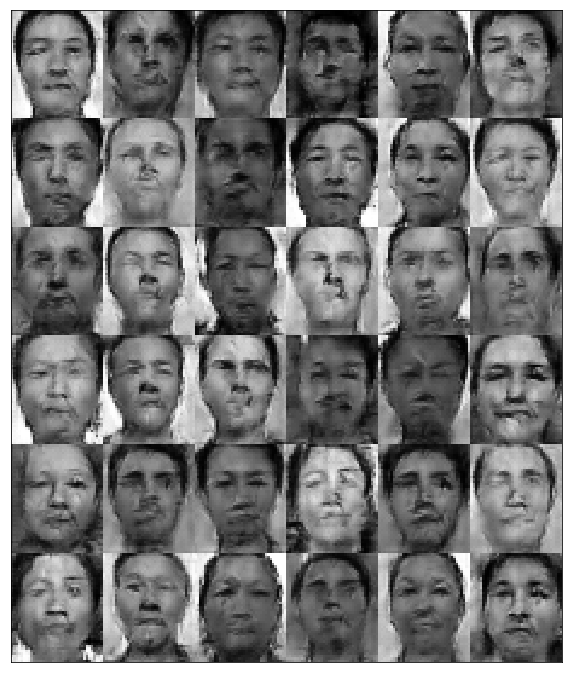

In [0]:
#@markdown - **由噪声生成 36 幅图像**
n = 6
canvas = np.empty((45 * n, 38 * n))
g_new = (g + 1.) / 2.
for i in range(n):
    # 将生成的图像映射至 [0, 1]
    for j in range(n):
        canvas[i * 45:(i + 1) * 45, j * 38:(j + 1) * 38] = g_new[i * 6 + j].reshape([45, 38])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 12))
ax.imshow(canvas, cmap='gray')
ax.set_xticks([]), ax.set_yticks([])
# img_name1 = os.path.join(event_path, 'generated_images_by_GAN1.jpg')
# plt.savefig(img_name1)
plt.show()

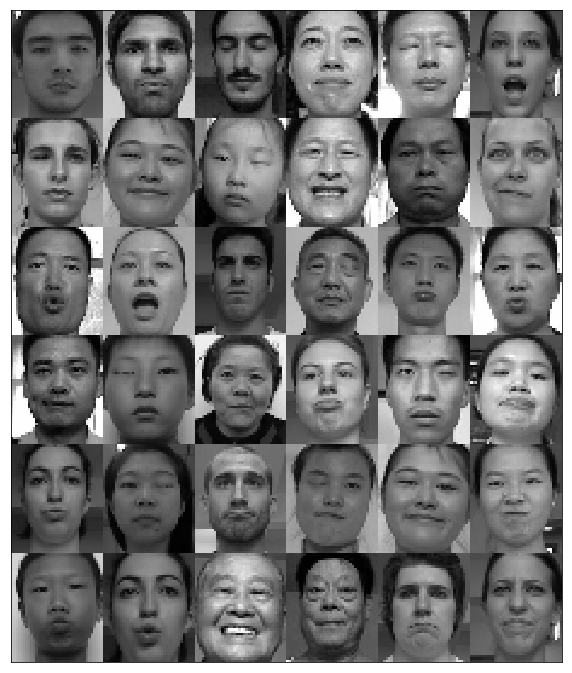

In [0]:
#@markdown - **36 幅原始图像**
n = 6
canvas = np.empty((45 * n, 38 * n))
g_new = (batch_x + 1.) / 2.
for i in range(n):
    # 将生成的图像映射至 [0, 1]
    for j in range(n):
        canvas[i * 45:(i + 1) * 45, j * 38:(j + 1) * 38] = g_new[i * 6 + j].reshape([45, 38])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 12))
ax.imshow(canvas, cmap='gray')
ax.set_xticks([]), ax.set_yticks([])
# img_name1 = os.path.join(event_path, 'generated_images_by_GAN1.jpg')
# plt.savefig(img_name1)
plt.show()

## Tensorboard 界面
> ![](https://github.com/jswanglp/MyML/blob/master/resources/summaries_DCGAN/FaceWarehouse/tensorboard_DCGAN.PNG?raw=true)